# Lab 4
## CartPole with Value-Based Agents (DQN Variants)

Objectives:
1. Train a **baseline DQN** on CartPole using **RL Zoo 3** (a training harness around Stable-Baselines3).
2. Diagnose **stability** by inspecting learning curves and evaluation performance.
3. Implement and train **Dueling DQN** (an architecture change) using Stable-Baselines3 directly.
4. On your own, implemnet **Double DQN**




Run on Google Colab:

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/duke-trust-lab/intro_modern_rl/blob/main/lab4/lab4.ipynb)

In [1]:
%pip install -q stable-baselines3==2.* sb3-contrib==2.* gymnasium matplotlib pandas pyyaml imageio ffmpeg-python
%pip install -q rl_zoo3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.3/566.3 kB 31.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 5.0.0 requires huggingface-hub<2.0,>=1.3.0, but you have huggingface-hub 0.36.1 which is incompatible.


In [2]:
import os
import glob
import time
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Video, display

import gymnasium as gym
import torch

### What DQN is doing

DQN learns an approximation of the action-value function:

Qθ(s,a)

A standard DQN target is:

y = r + γ max_a' Qθ⁻(s', a')

where:
- θ: online network parameters (updated every gradient step)
- θ⁻: target network parameters (updated more slowly)

DQN typically uses:
- **experience replay**: sample random mini-batches from a replay buffer (reduces correlation)
- **target network**: stabilizes the moving target in TD learning
- **ε-greedy exploration**: balance exploration vs exploitation

---

## Why use RL Zoo 3 for the baseline run?

RL Zoo provides:
- a clean, repeatable CLI training workflow
- standardized logging + saved best models
- video recording utilities

This lets us focus on:
- what the hyperparameters mean
- what the training curves tell us
- how evaluation differs from training


### Create RL Zoo YAML config for baseline DQN

In [3]:
ENV_ID = "CartPole-v1"
LOG_DIR = "logs"

os.makedirs(LOG_DIR, exist_ok=True)

dqn_config = {
    ENV_ID: {
        "policy": "MlpPolicy",
        "n_timesteps": float(6e4),
        "buffer_size": 20000,
        "learning_starts": 1000,
        "target_update_interval": 250,
        "exploration_fraction": 0.2,
        "exploration_final_eps": 0.06,
        "learning_rate": float(1e-3),
        "batch_size": 64,
        "train_freq": 32,
        "gradient_steps": 16,
        "gamma": 0.99,
        "optimize_memory_usage": False,
    }
}

with open("dqn_base.yaml", "w") as f:
    yaml.safe_dump(dqn_config, f, sort_keys=False)

print("Wrote dqn_base.yaml")

Wrote dqn_base.yaml


In [4]:
# Train a single baseline run (seed 0). You can later expand to multiple seeds.
seed = 0
cmd = f"python -m rl_zoo3.train --algo dqn --env {ENV_ID} -f {LOG_DIR}/ -c dqn_base.yaml --log-interval 1000 --seed {seed}"
print("Running:", cmd)
!{cmd}

Running: python -m rl_zoo3.train --algo dqn --env CartPole-v1 -f logs/ -c dqn_base.yaml --log-interval 1000 --seed 0
2026-02-03 23:38:38.249200: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-03 23:38:38.253764: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-03 23:38:38.267063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770161918.291914    4009 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770161918.299100    4009 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770161918.3

In [5]:
cmd = f"""python -m rl_zoo3.record_video \
  --algo dqn \
  --env {ENV_ID} \
  --folder {LOG_DIR}/ \
  -n 600 \
  --deterministic \
  --load-best
"""
print("Running:", cmd)
!{cmd}

Running: python -m rl_zoo3.record_video   --algo dqn   --env CartPole-v1   --folder logs/   -n 600   --deterministic   --load-best

2026-02-03 23:42:04.352342: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-03 23:42:04.363204: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-03 23:42:04.399583: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770162124.455168    4839 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770162124.471863    4839 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:

In [6]:
mp4s = glob.glob(os.path.join(LOG_DIR, "**", "*.mp4"), recursive=True)
mp4s_sorted = sorted(mp4s, key=os.path.getmtime, reverse=True)
print("Found videos:", len(mp4s_sorted))

if mp4s_sorted:
    print("Showing:", mp4s_sorted[0])
    display(Video(mp4s_sorted[0], embed=True))

Found videos: 1
Showing: logs/dqn/CartPole-v1_1/videos/best-model-dqn-CartPole-v1-step-0-to-step-600.mp4


## Diagnosing value estimation instability

In deep value-based RL, instability can show up as:
- learning curves that spike then collapse
- large oscillations in evaluation returns
- sensitivity to seed / hyperparameters
- apparently “good” training signals that don’t transfer to evaluation behavior



### Dueling DQN

Dueling DQN explicitly decomposes:

Q(s,a) = V(s) + A(s,a) − mean_a A(s,a)

Intuition:
- V(s): how good is the state (regardless of action)?
- A(s,a): how much better is action a compared to other actions in state s?

This can help in environments where:
- many actions have similar value
- learning V(s) is easier than learning full Q(s,a) directly

We will implement a custom DQN policy with dueling heads.


In [11]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback

SB3_LOG_BASE = "sb3_logs"
os.makedirs(SB3_LOG_BASE, exist_ok=True)

def make_env(env_id="CartPole-v1"):
    env = gym.make(env_id)
    env = Monitor(env)
    return env

def train_sb3(
    name: str,
    policy,
    env_id="CartPole-v1",
    total_timesteps=60_000,
    seed=0,
    policy_kwargs=None,
    algo_class=DQN # Add algo_class parameter with DQN as default
):
    env = make_env(env_id)
    eval_env = make_env(env_id)

    run_dir = os.path.join(SB3_LOG_BASE, name)
    os.makedirs(run_dir, exist_ok=True)

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=run_dir,
        log_path=run_dir,
        eval_freq=10_000,
        deterministic=True,
        render=False,
    )

    model = algo_class( # Use algo_class here
        policy,
        env,
        learning_rate=1e-3,
        buffer_size=20_000,
        learning_starts=1_000,
        batch_size=64,
        tau=1.0,                  # hard target updates
        target_update_interval=250,
        train_freq=32,
        gradient_steps=16,
        gamma=0.99,
        exploration_fraction=0.2,
        exploration_final_eps=0.06,
        policy_kwargs=policy_kwargs,
        verbose=0,
        seed=seed,
        device="cuda" if torch.cuda.is_available() else "cpu",
    )

    model.learn(total_timesteps=total_timesteps, callback=eval_callback)
    model.save(os.path.join(run_dir, "final_model"))
    return run_dir

### Define Dueling DQN policy

In [8]:
import torch.nn as nn
from stable_baselines3.dqn.policies import DQNPolicy, QNetwork

class DuelingQNetwork(QNetwork):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        hidden_dim = 256

        self.shared = nn.Sequential(
            nn.Linear(self.features_dim, hidden_dim),
            nn.ReLU(),
        )

        # Value head V(s)
        self.V = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

        # Advantage head A(s,a)
        self.A = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.action_space.n),
        )

    def forward(self, obs):
        features = self.extract_features(obs, self.features_extractor)
        h = self.shared(features)
        v = self.V(h)                          # [batch, 1]
        a = self.A(h)                          # [batch, n_actions]
        q = v + (a - a.mean(dim=1, keepdim=True))
        return q

class DuelingDQNPolicy(DQNPolicy):
    def make_q_net(self):
        net_args = self._update_features_extractor(self.net_args, features_extractor=None)
        return DuelingQNetwork(**net_args).to(self.device)

### Train baseline SB3 DQN + Dueling DQN

In [9]:
seed = 0
sb3_baseline_dir = train_sb3("dqn_baseline_seed0", policy="MlpPolicy", seed=seed)
sb3_dueling_dir  = train_sb3("dqn_dueling_seed0",  policy=DuelingDQNPolicy, seed=seed)

sb3_baseline_dir, sb3_dueling_dir

Eval num_timesteps=10000, episode_reward=119.40 +/- 6.62
Episode length: 119.40 +/- 6.62
New best mean reward!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Eval num_timesteps=20000, episode_reward=96.00 +/- 2.28
Episode length: 96.00 +/- 2.28
Eval num_timesteps=30000, episode_reward=100.20 +/- 2.79
Episode length: 100.20 +/- 2.79
Eval num_timesteps=40000, episode_reward=208.80 +/- 36.81
Episode length: 208.80 +/- 36.81
New best mean reward!
Eval num_timesteps=50000, episode_reward=500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=60000, episode_reward=500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=10000, episode_reward=115.40 +/- 2.06
Episode length: 115.40 +/- 2.06
New best mean reward!
Eval num_timesteps=20000, episode_reward=116.20 +/- 41.16
Episode length: 116.20 +/- 41.16
New best mean reward!
Eval num_timesteps=30000, episode_reward=135.00 +/- 3.03
Episode length: 135.00 +/- 3.03
New best mean reward!
Eval num_timesteps=40000, episode_reward=500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=50000, episode_reward=46.60 +/- 54.76
Episode 

('sb3_logs/dqn_baseline_seed0', 'sb3_logs/dqn_dueling_seed0')

### SB3 eval curves

In [ ]:
def load_eval_npz(run_dir):
    npz_path = os.path.join(run_dir, "evaluations.npz")
    if not os.path.exists(npz_path):
        return None
    data = np.load(npz_path)
    timesteps = data["timesteps"]
    results = data["results"]          # shape [n_evals, n_episodes]
    mean_reward = results.mean(axis=1)
    return pd.DataFrame({"timesteps": timesteps, "mean_reward": mean_reward})

b = load_eval_npz(sb3_baseline_dir)
d = load_eval_npz(sb3_dueling_dir)

plt.figure()
if b is not None:
    plt.plot(b["timesteps"], b["mean_reward"], label="SB3 DQN baseline")
if d is not None:
    plt.plot(d["timesteps"], d["mean_reward"], label="SB3 Dueling DQN")
plt.xlabel("timesteps")
plt.ylabel("eval mean reward")
plt.title("Evaluation Performance: Baseline vs Dueling")
plt.legend()
plt.show()

In [ ]:
import os
import imageio
import gymnasium as gym
import numpy as np

from stable_baselines3 import DQN

def record_sb3_rollout_mp4(
    model_zip_path: str,
    out_mp4_path: str,
    env_id: str = "CartPole-v1",
    n_steps: int = 600,          # 600 frames at 30 fps = 20 seconds
    fps: int = 30,
    deterministic: bool = True,
):
    os.makedirs(os.path.dirname(out_mp4_path), exist_ok=True)

    env = gym.make(env_id, render_mode="rgb_array")
    model = DQN.load(model_zip_path)

    obs, info = env.reset()
    frames = []

    for _ in range(n_steps):
        frame = env.render()
        frames.append(frame)

        action, _ = model.predict(obs, deterministic=deterministic)
        obs, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
            obs, info = env.reset()

    env.close()

    imageio.mimsave(out_mp4_path, frames, fps=fps)
    return out_mp4_path


In [ ]:
baseline_mp4 = record_sb3_rollout_mp4(
    model_zip_path=os.path.join(sb3_baseline_dir, "best_model.zip"),
    out_mp4_path=os.path.join(sb3_baseline_dir, "videos_manual", "baseline.mp4"),
    n_steps=600,
    fps=30,
)

dueling_mp4 = record_sb3_rollout_mp4(
    model_zip_path=os.path.join(sb3_dueling_dir, "best_model.zip"),
    out_mp4_path=os.path.join(sb3_dueling_dir, "videos_manual", "dueling.mp4"),
    n_steps=600,
    fps=30,
)

baseline_mp4, dueling_mp4


In [ ]:
from IPython.display import Video, display

display(Video(baseline_mp4, embed=True))
display(Video(dueling_mp4, embed=True))

### Checkpoint

**What happened?**


Dueling DQN learns faster at first because it can more easily estimate which states are good. But that same decomposition makes it more sensitive to noisy value estimates. Without Double DQN or careful tuning, those errors can compound and cause instability. Baseline DQN is slower but more robust here, which is why simple methods often outperform more advanced ones on small problems


### Double DQN

A common failure mode in value-based RL is **overestimation bias**.

Why?
- Q-values are learned estimates and are noisy.
- Taking `max_a Q(s,a)` tends to select actions with positive noise.

Baseline DQN target:
y = r + γ max_a' Qθ⁻(s', a')

Double DQN target (key idea: decouple selection and evaluation):
1) select action using online net:
   a* = argmax_a' Qθ(s', a')

2) evaluate that action using target net:
   y = r + γ Qθ⁻(s', a*)

This reduces maximization bias and often improves stability.

### Implementing Double DQN
with baseline policy

Algorithm change : modify how the DQN algorithm uses the target network

In [12]:
import torch
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.buffers import ReplayBuffer
from typing import Any, Dict, List, Optional, Tuple, Type, Union

class DoubleDQN(DQN):
    """
    Double DQN implementation.

    The key difference from regular DQN:
    - Regular DQN: target = r + γ * max_a' Q_target(s', a')
    - Double DQN: target = r + γ * Q_target(s', argmax_a' Q(s', a'))

    In other words:
    - Use the PRIMARY network to SELECT the best action
    - Use the TARGET network to EVALUATE that action's value
    """

    def train(self, gradient_steps: int, batch_size: int = 100) -> None:
        """
        Override the train method to implement Double DQN target calculation.
        """
        # Switch to train mode
        self.policy.set_training_mode(True)

        # Update learning rate according to schedule
        self._update_learning_rate(self.policy.optimizer)

        losses = []
        for _ in range(gradient_steps):
            # Sample replay buffer
            replay_data = self.replay_buffer.sample(batch_size, env=self._vec_normalize_env)

            with torch.no_grad():
                # === DOUBLE DQN MAGIC HAPPENS HERE ===

                # 1. Use PRIMARY network (q_net) to SELECT the best actions
                #    "Which action does my current policy think is best?"
                next_q_values_online = self.q_net(replay_data.next_observations)
                next_actions = next_q_values_online.argmax(dim=1, keepdim=True)  # [batch, 1]

                # 2. Use TARGET network (q_net_target) to EVALUATE those actions
                #    "What does my stable target network think that action is worth?"
                next_q_values_target = self.q_net_target(replay_data.next_observations)
                next_q_values = next_q_values_target.gather(1, next_actions).squeeze(1)  # [batch]

                # Regular DQN would do this instead (uses target network for BOTH):
                # next_q_values = self.q_net_target(replay_data.next_observations).max(dim=1)[0]

                # Compute target Q-values
                target_q_values = replay_data.rewards + (1 - replay_data.dones) * self.gamma * next_q_values

            # Get current Q-values estimates
            current_q_values = self.q_net(replay_data.observations)
            current_q_values = current_q_values.gather(1, replay_data.actions.long()).squeeze(1)

            # Compute loss (Huber loss by default in SB3)
            loss = torch.nn.functional.smooth_l1_loss(current_q_values, target_q_values)
            losses.append(loss.item())

            # Optimize the policy
            self.policy.optimizer.zero_grad()
            loss.backward()
            # Clip gradient norm
            torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.policy.optimizer.step()

        # Increase update counter
        self._n_updates += gradient_steps

        # Log losses
        self.logger.record("train/loss", np.mean(losses))
        self.logger.record("train/n_updates", self._n_updates, exclude="tensorboard")


# Training code
seed = 0

# Baseline DQN (already trained in your code)
sb3_baseline_dir = train_sb3("dqn_baseline_seed0", policy="MlpPolicy", seed=seed)

# Dueling DQN (already trained in your code)
sb3_dueling_dir = train_sb3("dqn_dueling_seed0", policy=DuelingDQNPolicy, seed=seed)

# Double DQN - new!
sb3_double_dir = train_sb3(
    "dqn_double_seed0",
    policy="MlpPolicy",  # Same architecture as baseline
    seed=seed,
    algo_class=DoubleDQN  # But different algorithm!
)

sb3_baseline_dir, sb3_dueling_dir, sb3_double_dir

Eval num_timesteps=10000, episode_reward=111.40 +/- 2.33
Episode length: 111.40 +/- 2.33
New best mean reward!
Eval num_timesteps=20000, episode_reward=96.20 +/- 2.32
Episode length: 96.20 +/- 2.32
Eval num_timesteps=30000, episode_reward=96.40 +/- 1.62
Episode length: 96.40 +/- 1.62
Eval num_timesteps=40000, episode_reward=171.40 +/- 14.81
Episode length: 171.40 +/- 14.81
New best mean reward!
Eval num_timesteps=50000, episode_reward=500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=60000, episode_reward=500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
Eval num_timesteps=10000, episode_reward=113.60 +/- 1.50
Episode length: 113.60 +/- 1.50
New best mean reward!
Eval num_timesteps=20000, episode_reward=137.00 +/- 3.29
Episode length: 137.00 +/- 3.29
New best mean reward!
Eval num_timesteps=30000, episode_reward=139.40 +/- 4.84
Episode length: 139.40 +/- 4.84
New best mean reward!
Eval num_timesteps=40000, episode_reward=500.00 +/- 0.00
Episode leng

/tmp/ipython-input-1413599340.py:59: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.smooth_l1_loss(current_q_values, target_q_values)


Eval num_timesteps=10000, episode_reward=9.60 +/- 0.49
Episode length: 9.60 +/- 0.49
New best mean reward!
Eval num_timesteps=20000, episode_reward=9.80 +/- 0.40
Episode length: 9.80 +/- 0.40
New best mean reward!
Eval num_timesteps=30000, episode_reward=9.20 +/- 0.98
Episode length: 9.20 +/- 0.98
Eval num_timesteps=40000, episode_reward=9.20 +/- 0.75
Episode length: 9.20 +/- 0.75
Eval num_timesteps=50000, episode_reward=9.40 +/- 0.80
Episode length: 9.40 +/- 0.80
Eval num_timesteps=60000, episode_reward=9.60 +/- 0.49
Episode length: 9.60 +/- 0.49


('sb3_logs/dqn_baseline_seed0',
 'sb3_logs/dqn_dueling_seed0',
 'sb3_logs/dqn_double_seed0')

### Train Double DQN with duelling policy

In [14]:
# Double DQN
sb3_double_dir_d = train_sb3(
    "dqn_double_seed0",
    policy= DuelingDQNPolicy,  # Same architecture as Duelling DQN
    seed=seed,
    algo_class=DoubleDQN  # But different algorithm!
)

sb3_double_dir_d

/tmp/ipython-input-1413599340.py:59: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.smooth_l1_loss(current_q_values, target_q_values)


Eval num_timesteps=10000, episode_reward=10.00 +/- 0.00
Episode length: 10.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=9.60 +/- 0.49
Episode length: 9.60 +/- 0.49
Eval num_timesteps=30000, episode_reward=9.40 +/- 0.49
Episode length: 9.40 +/- 0.49
Eval num_timesteps=40000, episode_reward=8.80 +/- 0.75
Episode length: 8.80 +/- 0.75
Eval num_timesteps=50000, episode_reward=9.80 +/- 0.75
Episode length: 9.80 +/- 0.75
Eval num_timesteps=60000, episode_reward=9.60 +/- 0.49
Episode length: 9.60 +/- 0.49


'sb3_logs/dqn_double_seed0'

### Train Double DQN with baseline policy

In [15]:
# Training code
seed = 0

# Double DQN - new!
sb3_double_dir_b = train_sb3(
    "dqn_double_seed0",
    policy="MlpPolicy",  # Same architecture as baseline
    seed=seed,
    algo_class=DoubleDQN  # But different algorithm
)

sb3_double_dir_b

/tmp/ipython-input-1413599340.py:59: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.smooth_l1_loss(current_q_values, target_q_values)


Eval num_timesteps=10000, episode_reward=9.40 +/- 0.49
Episode length: 9.40 +/- 0.49
New best mean reward!
Eval num_timesteps=20000, episode_reward=9.60 +/- 0.49
Episode length: 9.60 +/- 0.49
New best mean reward!
Eval num_timesteps=30000, episode_reward=8.60 +/- 0.49
Episode length: 8.60 +/- 0.49
Eval num_timesteps=40000, episode_reward=8.80 +/- 0.75
Episode length: 8.80 +/- 0.75
Eval num_timesteps=50000, episode_reward=9.80 +/- 0.40
Episode length: 9.80 +/- 0.40
New best mean reward!
Eval num_timesteps=60000, episode_reward=10.20 +/- 0.40
Episode length: 10.20 +/- 0.40
New best mean reward!


'sb3_logs/dqn_double_seed0'

SB3 Eval Curves

Plot evaluation of Baseline v. Dueling v. Double DQN ( both baseline and duellingdqn policy)

No event files found in sb3_logs/dqn_baseline_seed0
No event files found in sb3_logs/dqn_dueling_seed0
No event files found in sb3_logs/dqn_double_seed0
No event files found in sb3_logs/dqn_double_seed0


/tmp/ipython-input-1796046737.py:99: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right', fontsize=11, framealpha=0.9)


Figure saved to dqn_variants_comparison.png


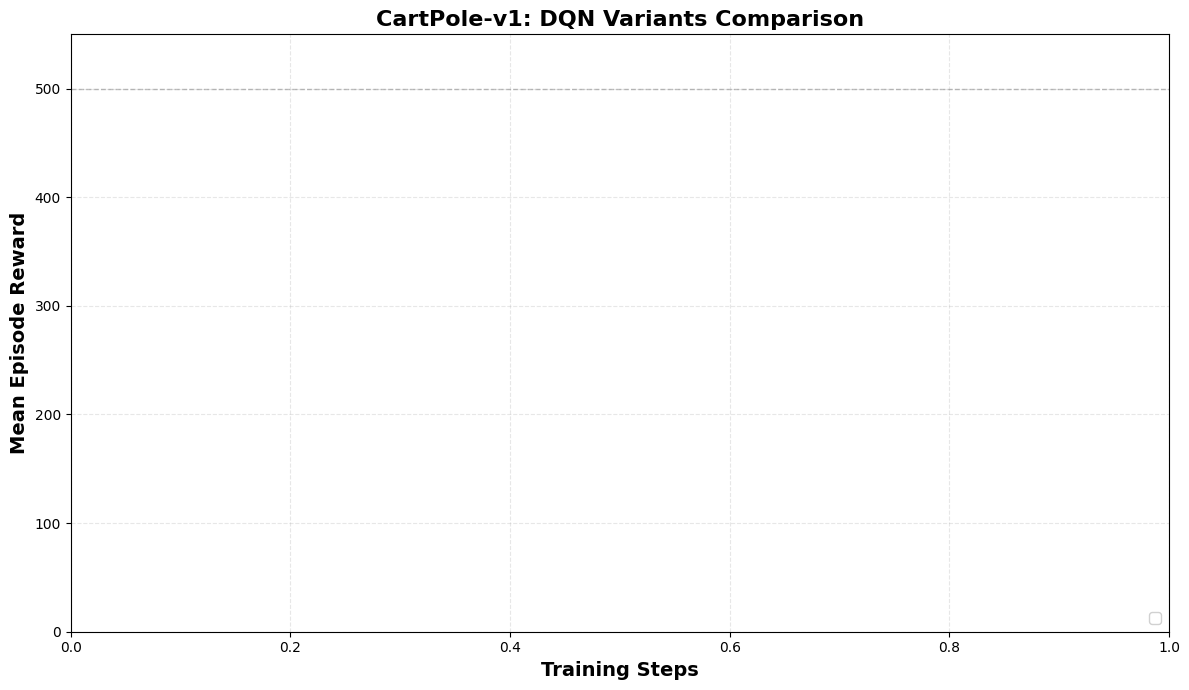

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

def load_tensorboard_data(log_dir, tag='rollout/ep_rew_mean'):
    """
    Load data from TensorBoard event files.

    Args:
        log_dir: Directory containing TensorBoard logs
        tag: Metric to extract (default: episode reward mean)

    Returns:
        DataFrame with 'step' and 'value' columns
    """
    from tensorboard.backend.event_processing import event_accumulator

    # Find the event file
    event_files = list(Path(log_dir).rglob('events.out.tfevents.*'))
    if not event_files:
        print(f"No event files found in {log_dir}")
        return pd.DataFrame({'step': [], 'value': []})

    # Load the most recent event file
    ea = event_accumulator.EventAccumulator(str(event_files[0]))
    ea.Reload()

    # Extract the specified tag
    if tag not in ea.Tags()['scalars']:
        print(f"Tag '{tag}' not found. Available tags: {ea.Tags()['scalars']}")
        return pd.DataFrame({'step': [], 'value': []})

    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]

    return pd.DataFrame({'step': steps, 'value': values})


def plot_all_agents_comparison(
    baseline_dir,
    dueling_dir,
    double_baseline_dir,
    double_dueling_dir,
    save_path=None
):
    """
    Plot comparison of all 4 DQN variants.

    Args:
        baseline_dir: Path to Baseline DQN logs
        dueling_dir: Path to Dueling DQN logs
        double_baseline_dir: Path to Double DQN (baseline policy) logs
        double_dueling_dir: Path to Double DQN (dueling policy) logs
        save_path: Optional path to save the figure
    """

    # Load data from all experiments
    agents = {
        'Baseline DQN': baseline_dir,
        'Dueling DQN': dueling_dir,
        'Double DQN (Baseline)': double_baseline_dir,
        'Double DQN (Dueling)': double_dueling_dir,
    }

    data = {}
    for name, log_dir in agents.items():
        df = load_tensorboard_data(log_dir, tag='rollout/ep_rew_mean')
        if not df.empty:
            data[name] = df
        else:
            print(f"Warning: No data loaded for {name}")

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 7))

    # Colors and styles for each agent
    styles = {
        'Baseline DQN': {'color': '#1f77b4', 'linestyle': '-', 'linewidth': 2.5},
        'Dueling DQN': {'color': '#ff7f0e', 'linestyle': '--', 'linewidth': 2.5},
        'Double DQN (Baseline)': {'color': '#2ca02c', 'linestyle': '-.', 'linewidth': 2.5},
        'Double DQN (Dueling)': {'color': '#d62728', 'linestyle': ':', 'linewidth': 3},
    }

    # Plot each agent
    for name, df in data.items():
        ax.plot(
            df['step'],
            df['value'],
            label=name,
            **styles[name]
        )

    # Formatting
    ax.set_xlabel('Training Steps', fontsize=14, fontweight='bold')
    ax.set_ylabel('Mean Episode Reward', fontsize=14, fontweight='bold')
    ax.set_title('CartPole-v1: DQN Variants Comparison', fontsize=16, fontweight='bold')
    ax.legend(loc='lower right', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_ylim([0, 550])  # CartPole max is 500, add some headroom

    # Add horizontal line at optimal performance
    ax.axhline(y=500, color='gray', linestyle='--', linewidth=1, alpha=0.5, label='Optimal (500)')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

    plt.show()

    return fig, ax


# Plot the comparison
fig, ax = plot_all_agents_comparison(
    baseline_dir=sb3_baseline_dir,
    dueling_dir=sb3_dueling_dir,
    double_baseline_dir=sb3_double_dir_b,
    double_dueling_dir=sb3_double_dir_d,
    save_path='dqn_variants_comparison.png'
)

Checkpoint : What Happens?